# Exercise 2: Physiological signals in affective computing

<center>Students : Akiyo Worou, Lorenz Frey, Yun Cheng </center>


## Libraries importation 

In [100]:
# Useful libraries
!pip install neurokit2
!pip install biosppy
!pip install heartpy
!pip install pickle5
from biosppy.signals import ecg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal,stats
import neurokit2 as nk
import pandas as pd
import heartpy as hp
import numpy as np
import os
import pickle5 as pickle
import pandas as pd

%matplotlib inline
from sklearn.model_selection import train_test_split,cross_validate,LeaveOneOut,cross_val_score,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics

## Data importation 

In [101]:
#folder_path = '/content/drive/MyDrive/Colab Notebooks/Ubicomp project/ex2_recordings'                 # change the path to get the data

In [102]:
folder_path = 'Exercise2_data/'

In [103]:
# data importation
participants_number = ["%.2d" % i for i in range(1,45)]

data=[]
for n in participants_number:
    with open (os.path.join(folder_path,'participant_' + n+'.pkl'),'rb') as f:
        datum=pickle.load(f)
        data.append(datum)

## Some useful functions

In [104]:
def low_pass_filter(cutoff,order,sampling_rate):
    sos = signal.butter(order, cutoff, 'lowpass', fs=sampling_rate, output='sos')
    return sos

def plot_filter_response(cutoff,order,sampling_rate):
    b, a = signal.butter(order, cutoff, btype='low', analog=True)
    w,h=signal.freqs(b,a)
    
    # plot filter response
    plt.figure()
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.axvline(x=cutoff, color='green') # cutoff frequency
    plt.title('low-pass filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.legend()
    plt.show()
    
def filtered_signal(data,time_span,cutoff,order,sampling_rate,verbose=False):
    sos = low_pass_filter(cutoff,order,sampling_rate)
    filtered_signal = signal.sosfilt(sos, data)
    if verbose==True:
        plt.figure()
        plt.plot(time_span[:1000] ,filtered_signal[:1000],label='filtered signal')
        plt.xlabel('time (ms)')
        plt.ylabel('data')
        plt.title('filtered data signal')
        plt.legend()
    return filtered_signal


def PSD(data,sampling_rate, nperseg=None,noverlap=None, nfft=None,verbose=False):
    freq,Psd=signal.welch(data,sampling_rate, nperseg=nperseg,noverlap=noverlap, nfft=nfft)
    
    if verbose==True:
        # looking for the cut index
        cut_index=0
        for i in range(len(freq)):
            if freq[i] >40:
                cut_index=i
                break
            
        plt.figure()
        plt.semilogy(freq[:cut_index],Psd[:cut_index])
        plt.xlabel('frequency (Hz)')
        plt.ylabel('PSD')
        plt.title('Power Spectral Density')
    return freq,Psd
        

def PSD_values(data,sampling_rate,a,b,N):  # N PSD values between [a,b]
    deltaR=(b-a)/(N+1)
    wanted_freq=[deltaR*i for i in range(1,N+2)]
    freq,Psd=PSD(data,sampling_rate,nfft=int(sampling_rate/deltaR))
    values=[]
    for m in freq:
        if 0<m <b:
            values.append(Psd[list(freq).index(m)])
    assert(len(values)==N)
    return values

def statistical_measurements(data):
    data_mean=np.mean(data, axis=0)
    data_std=np.std(data)
    data_kurtosis = stats.kurtosis(data,fisher=False)  # Using Pearson
    
    above_m_std=0
    below_m_std=0
    for i in range(len(data)):
        if data[i] > (data_mean+data_std):
            above_m_std+=1
        if data[i] <(data_mean-data_std):
            below_m_std+=1
    above_m_std/=len(data)
    below_m_std/=len(data)
    
    return [data_mean,data_std,data_kurtosis,above_m_std,below_m_std]


## 2.1 Feature extraction and data analysis
## 2.1.1 ECG



### ECG analysis function for a specific clip

In [105]:
def ECG_analysis(ID, record ,verbose=False):
    
    sampling_rate=data[ID]['FS_ECG']
    
    
    
    # analysing the recording 

    ECG_array = data[ID]['recordings'][record]['ECG']  # getting the ECG data

    time_span=ECG_array[:,0]

    # The ECG in Lead I is given by Left minus right
    ECG_signal=(ECG_array[:,2]-ECG_array[:,1])
    
    if verbose==True:
        # plot the first 1000 of ECG 
        plt.figure()
        plt.plot(ECG_signal[:1000])
        plt.title('Original ECG')
        
        # computed only for participant 1, clip 1 
        PSD(ECG_signal,sampling_rate, nperseg=15*sampling_rate,noverlap=10*sampling_rate,verbose=True)
        
    
    # filter response
    cutoff = 25
    order=5
    if verbose==True:
        # plot the filter response
        plot_filter_response(cutoff,order,sampling_rate)
    
    # Applying the filter to ECG
    filtered_ECG=filtered_signal(ECG_signal,time_span,cutoff,order,sampling_rate,verbose=verbose)
    
    # notch 
    notch=0.05
    filtered_ECG=hp.remove_baseline_wander(filtered_ECG, sampling_rate, cutoff = notch)
    
     # Ten low frequency [0, 2.4] Hz PSD
    PSD_tlf= PSD_values(filtered_ECG,sampling_rate,0,2.4,10)
    
    # four very slow frequency [0, 0.04] Hz PSD
    PSD_flf=PSD_values(filtered_ECG,sampling_rate,0,0.04,4)

    # getting the r peaks
    _, rpeaks = nk.ecg_peaks(filtered_ECG, sampling_rate=sampling_rate)
    rpeaks =rpeaks['ECG_R_Peaks']
    
    # plot filtered ECG with r peaks
    if verbose==True:
        plt.figure()
        plt.plot(time_span[:1000],filtered_ECG[:1000],label='filtered signal')
        plt.title('Filtered signal and peaks')
        for l in rpeaks:
            l_span=time_span[l]
            if l_span in time_span[:1000]:
                plt.axvline(x=l_span, label= 'Cutoff', c='red') 
        
            
    # the heart rate
    heart_rate=nk.ecg_rate(rpeaks,sampling_rate)
     
    # RR intervalls
    
    RR=[time_span[rpeaks[i+1]]-time_span[rpeaks[i]] for i in range(len(rpeaks)-1) ]
    
    # heart rate variability
    hr_var = [ RR[i+1]- RR[i] for i in range(len(RR)-1) ]
    
    
    
    
    return RR,heart_rate,hr_var,PSD_tlf,PSD_flf

### First Participant clip 1 analysis

No handles with labels found to put in legend.


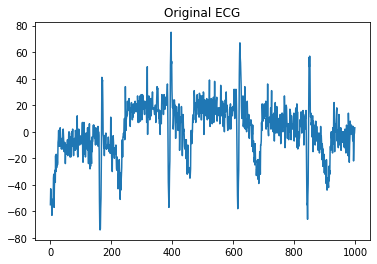

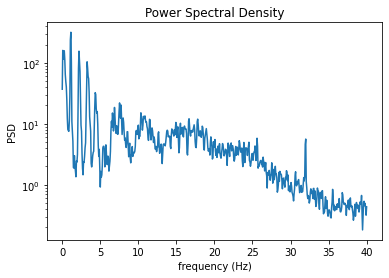

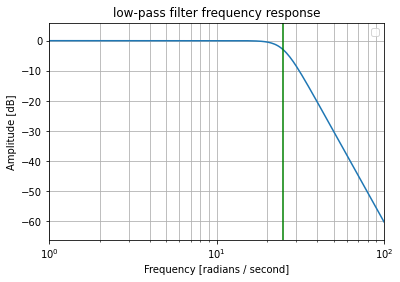

([882.8125,
  882.8125,
  890.625,
  792.96875,
  804.6875,
  820.3125,
  882.8125,
  878.90625,
  902.34375,
  824.21875,
  820.3125,
  812.5,
  839.84375,
  843.75,
  898.4375,
  945.3125,
  945.3125,
  867.1875,
  867.1875,
  878.90625,
  882.8125,
  847.65625,
  882.8125,
  914.0625,
  914.0625,
  878.90625,
  925.78125,
  953.125,
  957.03125,
  894.53125,
  925.78125,
  914.0625,
  941.40625,
  902.34375,
  917.96875,
  937.5,
  949.21875,
  949.21875,
  917.96875,
  937.5,
  929.6875,
  906.25,
  851.5625,
  906.25,
  937.5,
  960.9375,
  902.34375,
  941.40625,
  937.5,
  941.40625,
  414.0625,
  460.9375,
  437.5,
  476.5625,
  933.59375,
  863.28125,
  902.34375,
  929.6875,
  937.5,
  871.09375,
  886.71875,
  898.4375,
  910.15625,
  835.9375,
  863.28125,
  867.1875,
  929.6875,
  898.4375,
  898.4375,
  917.96875,
  933.59375,
  863.28125,
  894.53125,
  914.0625,
  941.40625,
  890.625,
  933.59375,
  929.6875,
  910.15625,
  875.0,
  902.34375,
  921.875,
  871.09375,
 

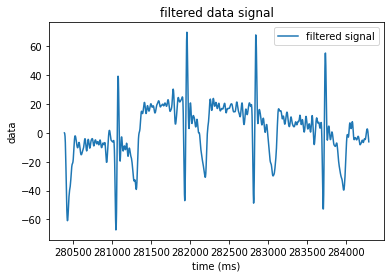

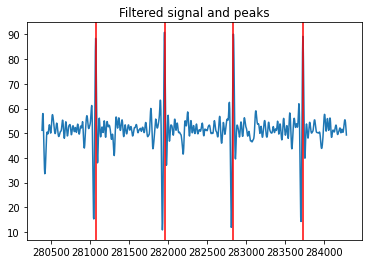

In [106]:
# Getting the PSD
ECG_analysis(0, 1 ,verbose=True)

### Artifacts detection plot

In [107]:
# artifact detection

def ArtifactDetect(rr_n, rr_n_minus, rr_n_plus, rr_k, cbd):
    if 300 <= rr_n and 2000 >= rr_n:
        if abs(rr_n - rr_n_minus) <= cbd:
            artifact = False
        else:
            artifact = True
    else:
        if abs(rr_n - rr_k) <= cbd:
            artifact = False
        else:
            if abs(rr_n - rr_n_minus) <= cbd and abs(rr_n - rr_n_plus) <= cbd:
                artifact = False  
            else:
                artifact = True
                
    return artifact

def ArtifactPercentage(participant_data):
    t_artifact = 0
    t_total = 0
    for j in range( len(participant_data) ):
        fs = participant_data[j]["FS_ECG"]
        for k in participant_data[j]['recordings'].keys():
            ecg_r = participant_data[j]["recordings"][k]['ECG'][:,1]
            ecg_l = participant_data[j]["recordings"][k]['ECG'][:,2]
            sig = ecg_l - ecg_r
            t = ecg.ecg(signal=sig, sampling_rate=fs, show=False)[0]
            sig_filtered = ecg.ecg(signal=sig, sampling_rate=fs, show=False)[1]
            r_peaks = ecg.ecg(signal=sig, sampling_rate=fs, show=False)[2]
            rr = np.diff(r_peaks)
            median_rr = np.median(rr)
            q1 = np.percentile(rr, 25)
            q3 = np.percentile(rr, 75)
            qd = (q3-q1)/2
            mad = (median_rr -2.3 * qd)/3
            med = 3.32 * qd
            cbd = (mad + med)/2

            artifacts = []
            rr_k = 0
            for i in range(0,len(rr)):
                try:
                    check_validity = ArtifactDetect(rr[i], rr[i-1], rr[i+1], rr_k, cbd )
                    artifacts.append(check_validity)
                    if check_validity:
                        rr_k = rr[i]
                except:
                    artifacts.append(0)
            t_artifact += sum(np.multiply(rr, artifacts))/1000 # [s]
            t_total += t[-1] # [s]

    artifact_percentage = (t_artifact/t_total)*100
    print('Percentage of ECG flagged as artifacts: {}%'.format(round(artifact_percentage,4)))
    return artifact_percentage

In [108]:
# ArtifactPercentage(data)

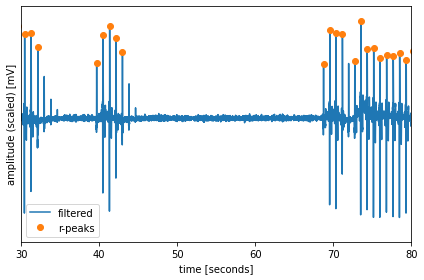

In [109]:
# plot artifact detection in participant 2 signal
ecg_r = data[1]["recordings"][1]['ECG'][:,1]
ecg_l = data[1]["recordings"][1]['ECG'][:,2]
fs = data[1]["FS_ECG"]
sig = ecg_l - ecg_r

artifact = ecg.ecg(signal=sig, sampling_rate=fs, show=False)
t_bio = artifact[0]
signal_bio = artifact[1]
rpeaks_idc = artifact[2]
fig = plt.figure()#figsize=(8/2.54,5/2.54))
plt.plot(t_bio, signal_bio, label = 'filtered')
plt.plot(t_bio[rpeaks_idc], signal_bio[rpeaks_idc], 'o', label='r-peaks')
plt.xlabel('time [seconds]')
plt.ylabel('amplitude (scaled) [mV]')
plt.xlim(30, 80)
plt.yticks([])
plt.tight_layout()
plt.legend()
plt.show()
#plt.savefig('artifacts.pgf', format='pgf')

### Features extractions from the recordings

In [110]:
# getting the last 50 seconds for ECG = 50000 milliseconds

for ID in range(len(data)):

    for i in data[ID]['recordings'].keys():
        ECG_1=data[0]['recordings'][i]['ECG']
        time_span=ECG_1[:,0]
        n=len(time_span)
        cut_index=0
        for j in range(1,n):
            if (time_span[-1]-time_span[n-j])>50000:
                cut_index=j+1
                break
        data[ID]['recordings'][i]['ECG']=ECG_1[cut_index:]


In [111]:
def ECG_features_extration():
    col =  ['participant_ID','recording']+ ['PSD_tlf_'+str(i) for i in range(1,11)] + \
    ['PSD_flf_'+str(i) for i in range(1,5)] + \
    ['RR_mean','RR_std','RR_kurtosis','RR_above','RR_below']+  \
    ['hr_mean','hr_std','hr_kurtosis','hr_above','hr_below']+   \
    ['hrv_mean','hrv_std','hrv_kurtosis','hrv_above','hrv_below']
    
    ECG_features= pd.DataFrame(columns=col)
    for ID in range(len(data)):

        for i in data[ID]['recordings'].keys():
            RR,heart_rate,hr_var,PSD_tlf,PSD_flf = ECG_analysis(ID, i, verbose=False)
            
            Big_list= [int(ID+1),int(i)]+PSD_tlf+PSD_flf+statistical_measurements(RR)+ \
            statistical_measurements(heart_rate)+ statistical_measurements(hr_var)
            
            n=len(ECG_features)
            ECG_features.loc[n]=Big_list
    ECG_features = ECG_features.astype({"participant_ID": int, "recording": int})
    return ECG_features

In [112]:
ECG_features=ECG_features_extration()
ECG_features

,participant_ID,recording,PSD_tlf_1,PSD_tlf_2,PSD_tlf_3,PSD_tlf_4,PSD_tlf_5,PSD_tlf_6,PSD_tlf_7,PSD_tlf_8,...,hr_mean,hr_std,hr_kurtosis,hr_above,hr_below,hrv_mean,hrv_std,hrv_kurtosis,hrv_above,hrv_below
0,1,1,0.023458,0.019937,0.015990,0.013766,0.015039,0.020597,0.030211,0.043302,...,67.398446,2.327944,2.789152,0.151515,0.166667,-0.427246,33.977620,2.426889,0.109375,0.171875
1,1,2,0.013372,0.011560,0.009526,0.008601,0.010194,0.015232,0.023718,0.034796,...,70.598360,2.239210,2.482507,0.160000,0.160000,2.547554,25.669551,2.787563,0.173913,0.217391
2,1,3,0.026298,0.025166,0.023759,0.022638,0.022565,0.024774,0.031149,0.043836,...,83.767521,6.438563,2.015210,0.230769,0.230769,8.877841,29.613156,1.838342,0.272727,0.272727
3,1,4,0.056171,0.047546,0.037499,0.030450,0.029671,0.036419,0.050267,0.070173,...,66.329014,13.486771,22.290932,0.045455,0.000000,-4.092262,106.885166,16.181099,0.047619,0.023810
4,1,5,0.040172,0.033929,0.026638,0.021961,0.023227,0.032270,0.048873,0.071187,...,70.095805,3.409117,2.696718,0.187500,0.156250,-0.441028,28.791464,3.207785,0.145161,0.112903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,44,32,0.026868,0.023558,0.020244,0.019246,0.022373,0.030448,0.043436,0.061009,...,62.940334,2.115919,2.755313,0.176471,0.235294,-2.083333,32.459243,2.528979,0.133333,0.200000
1451,44,33,0.021099,0.018103,0.014653,0.012617,0.013740,0.019013,0.028368,0.040979,...,69.807611,2.307190,2.252862,0.133333,0.200000,-2.790179,20.400766,2.924889,0.107143,0.214286
1452,44,34,0.023773,0.020028,0.015991,0.013779,0.014752,0.019213,0.026901,0.037886,...,78.711993,12.415485,1.859235,0.263158,0.105263,10.110294,43.971399,2.105040,0.235294,0.117647
1453,44,35,0.013590,0.012094,0.011057,0.012063,0.016372,0.024515,0.036365,0.051624,...,66.728571,12.934705,23.065923,0.038462,0.000000,0.312500,95.606105,20.983469,0.020000,0.020000


### Addding additional features to the ECG features

In [113]:

def additional_ECG_features():

    col = ['participant_ID','recording']+['ECG_HRV_pNN20','ECG_HRV_pNN50','ECG_HRV_SD1SD2','ECG_HRV_RMSSD','ECG_HRV_SampEn']
    ECG_additional_features= pd.DataFrame(columns=col)
    for ID in range(len(data)):

        for i in data[ID]['recordings'].keys():
            sampling_rate=data[ID]['FS_ECG']
    
            ECG_array = data[ID]['recordings'][i]['ECG']  # getting the ECG data

            time_span=ECG_array[:,0]

            # The ECG in Lead I is given by Left minus right
            ECG_signal=(ECG_array[:,2]-ECG_array[:,1])
            
            # filter response
            cutoff = 25
            order=5
            
            # Applying the filter to ECG
            filtered_ECG=filtered_signal(ECG_signal,time_span,cutoff,order,sampling_rate,verbose=False)
            
            # notch 
            notch=0.05
            filtered_ECG=hp.remove_baseline_wander(filtered_ECG, sampling_rate, cutoff = notch)
            
            df, info = nk.ecg.ecg_process(filtered_ECG, sampling_rate=sampling_rate)
            
            analyze_df = nk.ecg.ecg_analyze(df, sampling_rate=sampling_rate,method='interval-related')
            
            sub_features = analyze_df[['HRV_pNN20','HRV_pNN50','HRV_SD1SD2','HRV_RMSSD','HRV_SampEn']]
            #print(sub_features)
            
            Big_list= [int(ID+1),int(i)]+list(sub_features.values[0])
            n=len(ECG_additional_features)
            ECG_additional_features.loc[n]=Big_list
    ECG_additional_features = ECG_additional_features.astype({"participant_ID": int, "recording": int})
    return ECG_additional_features

In [114]:
ECG_additional_features=additional_ECG_features()

/home/cloud/anaconda3/envs/py38/lib/python3.8/site-packages/neurokit2/signal/signal_psd.py:109: NeuroKitWarning: The duration of recording is too short to support a sufficiently long window for high frequency resolution. Consider using a longer recording or increasing the `min_frequency`
  warn(
/home/cloud/anaconda3/envs/py38/lib/python3.8/site-packages/neurokit2/signal/signal_psd.py:109: NeuroKitWarning: The duration of recording is too short to support a sufficiently long window for high frequency resolution. Consider using a longer recording or increasing the `min_frequency`
  warn(
/home/cloud/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cloud/anaconda3/envs/py38/lib/python3.8/site-packages/neurokit2/signal/signal_psd.py:109: NeuroKitWarning: The duration of recording is too short to support a sufficiently long window for high frequency resolution. Consi

In [115]:
# final ecg features
ECG_features = pd.merge(ECG_features,ECG_additional_features,on=['participant_ID','recording'])
ECG_features

,participant_ID,recording,PSD_tlf_1,PSD_tlf_2,PSD_tlf_3,PSD_tlf_4,PSD_tlf_5,PSD_tlf_6,PSD_tlf_7,PSD_tlf_8,...,hrv_mean,hrv_std,hrv_kurtosis,hrv_above,hrv_below,ECG_HRV_pNN20,ECG_HRV_pNN50,ECG_HRV_SD1SD2,ECG_HRV_RMSSD,ECG_HRV_SampEn
0,1,1,0.023458,0.019937,0.015990,0.013766,0.015039,0.020597,0.030211,0.043302,...,-0.427246,33.977620,2.426889,0.109375,0.171875,52.307692,16.923077,0.677388,34.856579,2.036882
1,1,2,0.013372,0.011560,0.009526,0.008601,0.010194,0.015232,0.023718,0.034796,...,2.547554,25.669551,2.787563,0.173913,0.217391,41.666667,8.333333,0.536495,26.254508,inf
2,1,3,0.026298,0.025166,0.023759,0.022638,0.022565,0.024774,0.031149,0.043836,...,8.877841,29.613156,1.838342,0.272727,0.272727,58.333333,8.333333,0.261652,29.865458,inf
3,1,4,0.056171,0.047546,0.037499,0.030450,0.029671,0.036419,0.050267,0.070173,...,-4.092262,106.885166,16.181099,0.047619,0.023810,61.904762,30.952381,0.512345,40.470986,inf
4,1,5,0.040172,0.033929,0.026638,0.021961,0.023227,0.032270,0.048873,0.071187,...,-0.441028,28.791464,3.207785,0.145161,0.112903,34.920635,14.285714,0.384810,29.100907,1.473306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,44,32,0.026868,0.023558,0.020244,0.019246,0.022373,0.030448,0.043436,0.061009,...,-2.083333,32.459243,2.528979,0.133333,0.200000,50.000000,12.500000,0.529006,30.922766,-inf
1451,44,33,0.021099,0.018103,0.014653,0.012617,0.013740,0.019013,0.028368,0.040979,...,-2.790179,20.400766,2.924889,0.107143,0.214286,24.137931,6.896552,0.389720,20.957937,inf
1452,44,34,0.023773,0.020028,0.015991,0.013779,0.014752,0.019213,0.026901,0.037886,...,10.110294,43.971399,2.105040,0.235294,0.117647,66.666667,33.333333,0.190485,45.346954,1.098612
1453,44,35,0.013590,0.012094,0.011057,0.012063,0.016372,0.024515,0.036365,0.051624,...,0.312500,95.606105,20.983469,0.020000,0.020000,51.020408,8.163265,0.603961,28.432339,1.466337


In [116]:
ECG_features.isnull().sum()

participant_ID    0
recording         0
PSD_tlf_1         0
PSD_tlf_2         0
PSD_tlf_3         0
PSD_tlf_4         0
PSD_tlf_5         0
PSD_tlf_6         0
PSD_tlf_7         0
PSD_tlf_8         0
PSD_tlf_9         0
PSD_tlf_10        0
PSD_flf_1         0
PSD_flf_2         0
PSD_flf_3         0
PSD_flf_4         0
RR_mean           0
RR_std            0
RR_kurtosis       0
RR_above          0
RR_below          0
hr_mean           0
hr_std            0
hr_kurtosis       0
hr_above          0
hr_below          0
hrv_mean          0
hrv_std           0
hrv_kurtosis      0
hrv_above         0
hrv_below         0
ECG_HRV_pNN20     0
ECG_HRV_pNN50     0
ECG_HRV_SD1SD2    0
ECG_HRV_RMSSD     0
ECG_HRV_SampEn    0
dtype: int64

## 2.1.2 EMO

In [117]:
def EMO_features_extraction():
    col =  ['participant_ID','recording']
    stats_col= [['EMO_' +str(i)+'_mean','EMO_' +str(i)+'_std','EMO_' +str(i)+'_kurtosis','EMO_' +str(i)+'_above','EMO_' +str(i)+'_below']for i in range(1,13) ]
    for el_col in stats_col:
        col+=el_col
    EMO_features= pd.DataFrame(columns=col)
    for ID in range(len(data)):

        for i in data[ID]['recordings'].keys():
            L=[]
            for j in range(1,13):
                L.append(data[ID]['recordings'][i]['EMO'][:,j] )
            
            Big_list= [int(ID+1),int(i)]
            for l in L:
                Big_list+=statistical_measurements(l)
            n=len(EMO_features)
            EMO_features.loc[n]=Big_list
    EMO_features = EMO_features.astype({"participant_ID": int, "recording": int})
    return EMO_features

In [118]:
EMO_features=EMO_features_extraction()
EMO_features

,participant_ID,recording,EMO_1_mean,EMO_1_std,EMO_1_kurtosis,EMO_1_above,EMO_1_below,EMO_2_mean,EMO_2_std,EMO_2_kurtosis,...,EMO_11_mean,EMO_11_std,EMO_11_kurtosis,EMO_11_above,EMO_11_below,EMO_12_mean,EMO_12_std,EMO_12_kurtosis,EMO_12_above,EMO_12_below
0,1,1,0.076504,0.135977,3.609298,0.148148,0.137914,-0.051769,0.037112,2.924558,...,0.654579,0.410757,5.738354,0.125244,0.083821,0.298017,0.227077,7.804688,0.113548,0.035088
1,1,2,-0.248809,0.257405,2.052849,0.177215,0.212956,0.048417,0.035022,4.156554,...,0.129372,0.328218,6.307507,0.110946,0.048399,0.131276,0.193881,6.619233,0.110946,0.050633
2,1,3,-0.033304,0.084982,3.333826,0.152878,0.141187,-0.016992,0.022987,4.012434,...,0.646676,0.327056,5.948239,0.105216,0.071043,0.281162,0.201501,10.127922,0.087230,0.039568
3,1,4,-0.153727,0.076249,2.873837,0.156909,0.162763,0.004153,0.021428,3.674953,...,-0.070347,0.376453,4.844572,0.141101,0.105972,-0.126785,0.193466,6.172368,0.128806,0.055621
4,1,5,-0.869348,1.288132,1.905414,0.000000,0.274490,0.019920,0.040092,3.077544,...,0.136676,0.291850,6.550466,0.119841,0.080060,0.057257,0.197584,5.232278,0.151169,0.073098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,44,32,-0.092968,0.361847,22.297456,0.160330,0.054054,0.013389,0.048056,24.296451,...,-0.128927,0.097175,11.747222,0.122309,0.138800,0.079469,0.124294,9.416744,0.120476,0.083830
1451,44,33,-0.149358,0.143636,3.606672,0.142552,0.142125,-0.006418,0.025004,2.494543,...,-0.154771,0.066187,2.864591,0.162612,0.157490,0.064163,0.064500,8.820262,0.123773,0.140418
1452,44,34,0.112016,0.141591,9.857645,0.134775,0.116473,-0.008073,0.026074,3.321358,...,-0.267354,0.089091,2.785460,0.168885,0.153078,0.169323,0.087062,3.803375,0.143927,0.144759
1453,44,35,0.315480,0.129729,6.317390,0.100943,0.097060,-0.003195,0.018199,3.109426,...,-0.361454,0.066752,3.394106,0.159734,0.146423,0.176724,0.079696,12.741830,0.083749,0.078203


## 2.1.3 EDA

### ECG analysis function for a specific clip

In [119]:
def EDA_analysis(ID, record ,verbose=False):
    
    sampling_rate=data[ID]['FS_GSR']
    t_window = sampling_rate * 50
    
    # analysing the recording 

    GSR_array = data[ID]['recordings'][record]['GSR']  # getting the GSR data

    time_span=GSR_array[:,0]

    # The GSR in Lead I is given by Left minus right
    GSR_signal=GSR_array[:,1]
    
    if verbose==True:
        # plot GSR
        plt.figure(figsize=(20, 4))
        plt.plot(GSR_signal)
        plt.title('Original GSR')
        
        # computed only for participant 2, clip 1 
        PSD(GSR_signal,sampling_rate, nperseg=15*sampling_rate,noverlap=10*sampling_rate,verbose=True)
        
    
    # filter response
    cutoff = 1.99
    order=3
    if verbose==True:
        # plot the filter response
        plot_filter_response(cutoff,order,sampling_rate)
    
    # Applying the filter to GSR
    filtered_GSR=filtered_signal(GSR_signal,time_span,cutoff,order,sampling_rate,verbose=verbose)
    
    # Ten low frequency [0, 2.4] Hz PSD
    PSD_tlf= PSD_values(filtered_GSR,sampling_rate,0,2.4,10)
    
    # four very slow frequency [0, 0.04] Hz PSD
    PSD_flf=PSD_values(filtered_GSR,sampling_rate,0,0.04,4)
    
    # required features for GSR
    features_list=[]
    skin_conductance=1/np.array(filtered_GSR)
    # 01
    features_list.append(np.mean(filtered_GSR))
    
    first_derivative=np.gradient(filtered_GSR)
    # 02
    features_list.append(np.mean(first_derivative))
    # 03
    features_list.append(np.mean(np.absolute(first_derivative)))
    #04
    neg_derivative=[neg for neg in first_derivative if neg <0]
    features_list.append(np.mean(neg_derivative ))
    #05
    
    features_list.append(len(neg_derivative) * 1000/(sampling_rate*(time_span[-1]-time_span[0]))) # [-]
    #06
    features_list.append(np.std(filtered_GSR))
    #07
    features_list.append( len(signal.argrelextrema(skin_conductance, np.less)[0] ))
    #08
    
    maxima, _ = signal.find_peaks(filtered_GSR)
    minima, _ = signal.find_peaks(-filtered_GSR)
    if maxima[-1] < minima[-1]:
        minima = minima[0:-1]
    if maxima[0] < minima[0]:
        maxima = maxima[1:]
    features_list.append(sum(time_span[maxima] - time_span[minima])/(len(maxima))) #[ms]
    #09
    features_list+=PSD_flf
    
    #10
    features_list.append(np.std(skin_conductance))
    #11
    
    first_derivative_conductance=np.gradient(skin_conductance)
    features_list.append(np.mean(first_derivative_conductance))
    #12
    features_list.append(np.mean(np.absolute(first_derivative_conductance)))
    #13
    second_derivative_conductance = np.gradient(first_derivative_conductance)
    features_list.append(np.mean(np.absolute(second_derivative_conductance)))
    #14
    features_list.append(len(signal.argrelmin(filtered_GSR)[0]))
    #15
    features_list+=list(np.log(PSD_tlf))
    
    return features_list

### Second participant Clip 1 analysis

No handles with labels found to put in legend.


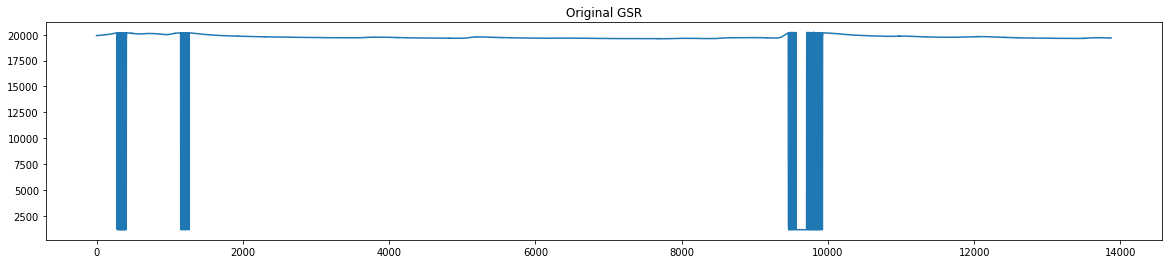

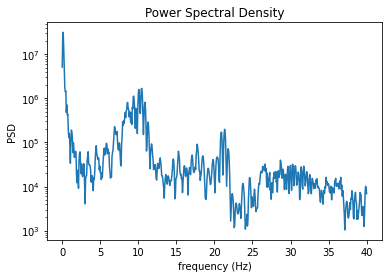

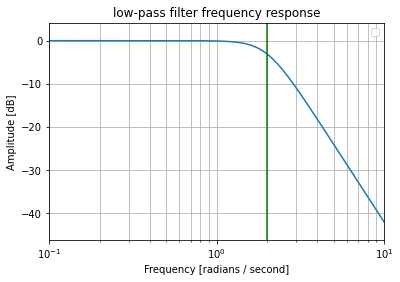

[19144.35589068596,
 1.419325195885512,
 8.069585184396729,
 -4.641264554815179,
 0.7164792387543253,
 2773.4770758526865,
 59,
 522.6293103448276,
 449966.623126269,
 451906.2668133782,
 455133.12597666,
 459638.3995252112,
 0.004071855209276112,
 -4.873399881543067e-05,
 4.894669466961089e-05,
 3.5568084718084255e-05,
 58,
 13.66017442320075,
 14.158249523219027,
 14.061071847421768,
 13.46360529704397,
 12.549802847043669,
 11.775192439823561,
 11.371439784767132,
 10.981128120710586,
 10.43067449505519,
 9.822147963286548]

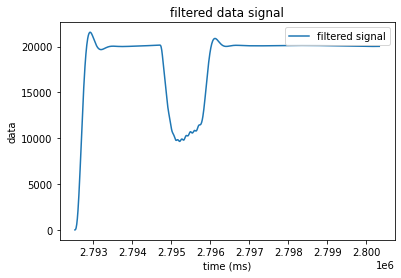

In [120]:
EDA_analysis(1,1,verbose=True)

### Features extractions from the recordings

In [121]:
# getting the last 50 seconds for EDA = 50000 milliseconds

for ID in range(len(data)):

    for i in data[ID]['recordings'].keys():
        GSR_data=data[0]['recordings'][i]['GSR']
        time_span=GSR_data[:,0]
        n=len(time_span)
        cut_index=0
        for j in range(1,n):
            if (time_span[-1]-time_span[n-j])>50000:
                cut_index=j+1
                break
        data[ID]['recordings'][i]['GSR']=GSR_data[cut_index:]

In [122]:
def GSR_features_extraction():

    features_col1=['EDA_'+str(i) for i in range(1,9)]
    features_col2=['EDA_'+str(i) for i in range(10,15)]

    col = ['participant_ID','recording'] + features_col1+ ['PSD_flf_'+str(i) for i in range(1,5)] + features_col2+['logPSD_tlf_'+str(i) for i in range(1,11)]
    
    
    GSR_features= pd.DataFrame(columns=col)
    for ID in range(len(data)):

        for i in data[ID]['recordings'].keys():
            L=[]
            
            Big_list= [int(ID+1),int(i)]
            # update big list
            Big_list+=EDA_analysis(ID, i,verbose=False)
            n=len(GSR_features)
            GSR_features.loc[n]=Big_list
    GSR_features = GSR_features.astype({"participant_ID": int, "recording": int})
    return GSR_features

In [123]:
GSR_features=GSR_features_extraction()
GSR_features

,participant_ID,recording,EDA_1,EDA_2,EDA_3,EDA_4,EDA_5,EDA_6,EDA_7,EDA_8,...,logPSD_tlf_1,logPSD_tlf_2,logPSD_tlf_3,logPSD_tlf_4,logPSD_tlf_5,logPSD_tlf_6,logPSD_tlf_7,logPSD_tlf_8,logPSD_tlf_9,logPSD_tlf_10
0,1,1,36126.693284,4.772126,5.892398,-0.826425,0.677872,1719.241755,20.0,980.263158,...,12.604859,11.929612,10.469485,6.806748,8.285249,8.464484,8.659337,8.861347,8.648627,8.345591
1,1,2,18108.671905,6.716020,8.306116,-1.298898,0.612320,1439.779249,6.0,1564.062500,...,12.297614,11.620070,10.157457,6.615273,8.002481,8.164412,8.363316,8.565075,8.351503,8.047740
2,1,3,17906.935279,14.674148,17.725946,-2.229468,0.684976,2114.186395,4.0,888.020833,...,13.210491,12.534677,11.074176,7.425095,8.892985,9.072383,9.266667,9.467887,9.255093,8.951246
3,1,4,18094.237858,3.566811,4.333526,-0.714446,0.536684,1040.446697,19.0,802.517361,...,11.615471,10.940438,9.480083,5.818701,7.298760,7.474151,7.669583,7.872876,7.659378,7.355595
4,1,5,18201.241906,2.578303,3.256289,-0.510186,0.664544,897.407087,15.0,1202.566964,...,11.309410,10.639984,9.198204,5.700681,6.958074,7.153407,7.349020,7.551234,7.340964,7.037396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,44,32,17720.241393,8.731645,10.492098,-1.409738,0.624695,1622.264258,13.0,468.750000,...,12.547722,11.871984,10.409903,6.715887,8.228595,8.406571,8.602071,8.804739,8.591020,8.286953
1451,44,33,18063.442429,5.668670,6.868832,-1.219020,0.492417,1319.391989,8.0,1776.785714,...,12.101272,11.426445,9.968667,6.356514,7.781908,7.959804,8.154948,8.357435,8.145121,7.841234
1452,44,34,17912.196168,9.637890,11.691758,-1.291771,0.795406,1717.360808,3.0,1300.781250,...,12.713646,12.039396,10.579690,6.876847,8.382446,8.561256,8.761893,8.967334,8.753201,8.450089
1453,44,35,18189.521208,3.008833,3.796450,-0.569727,0.691338,974.148429,14.0,1090.144231,...,11.452122,10.776997,9.317897,5.774988,7.150065,7.308954,7.510779,7.716617,7.502267,7.198776


In [124]:
GSR_features.isnull().sum()

participant_ID    0
recording         0
EDA_1             0
EDA_2             0
EDA_3             0
EDA_4             0
EDA_5             0
EDA_6             0
EDA_7             0
EDA_8             0
PSD_flf_1         0
PSD_flf_2         0
PSD_flf_3         0
PSD_flf_4         0
EDA_10            0
EDA_11            0
EDA_12            0
EDA_13            0
EDA_14            0
logPSD_tlf_1      0
logPSD_tlf_2      0
logPSD_tlf_3      0
logPSD_tlf_4      0
logPSD_tlf_5      0
logPSD_tlf_6      0
logPSD_tlf_7      0
logPSD_tlf_8      0
logPSD_tlf_9      0
logPSD_tlf_10     0
dtype: int64

### Addding additional features to the EDA features

In [125]:
def additional_GSR_features():

    col = ['participant_ID','recording']+['EDA_SCR_Height','EDA_SCR_Amplitude','EDA_SCR_RiseTime','EDA_SCR_Recovery','EDA_SCR_RecoveryTime']
    GSR_additional_features= pd.DataFrame(columns=col)
    for ID in range(len(data)):

        for i in data[ID]['recordings'].keys():
            sampling_rate=data[ID]['FS_GSR']
    
            GSR_array = data[ID]['recordings'][i]['GSR']  # getting the GSR data

            time_span=GSR_array[:,0]

            # The GSR in Lead I is given by Left minus right
            GSR_signal= GSR_array[:,1]
            
            # filter response
            cutoff = 1.99
            order=3
            
            # Applying the filter to GSR
            filtered_GSR=filtered_signal(GSR_signal,time_span,cutoff,order,sampling_rate,verbose=False)
            
            # notch 
            notch=0.05
            filtered_GSR=hp.remove_baseline_wander(filtered_GSR, sampling_rate, cutoff = notch)

            df, info = nk.eda_process(filtered_GSR, sampling_rate=sampling_rate)
            analyze_df = nk.eda_analyze(df, sampling_rate=sampling_rate,method='interval-related')
        
            sub_features = [np.mean(info['SCR_Height']),np.mean(info['SCR_Amplitude']),np.mean(info['SCR_RiseTime']),np.mean(info['SCR_Recovery']),np.mean(info['SCR_RecoveryTime'])]
            
            Big_list= [int(ID+1),int(i)] + list(sub_features)
            
            n=len(GSR_additional_features)
            GSR_additional_features.loc[n]=Big_list
    GSR_additional_features = GSR_additional_features.astype({"participant_ID": int, "recording": int})
    return GSR_additional_features

In [126]:
GSR_additional_features=additional_GSR_features()

In [127]:
# Final EDA features
GSR_features = pd.merge(GSR_features,GSR_additional_features,on=['participant_ID','recording'])
GSR_features

,participant_ID,recording,EDA_1,EDA_2,EDA_3,EDA_4,EDA_5,EDA_6,EDA_7,EDA_8,...,logPSD_tlf_6,logPSD_tlf_7,logPSD_tlf_8,logPSD_tlf_9,logPSD_tlf_10,EDA_SCR_Height,EDA_SCR_Amplitude,EDA_SCR_RiseTime,EDA_SCR_Recovery,EDA_SCR_RecoveryTime
0,1,1,36126.693284,4.772126,5.892398,-0.826425,0.677872,1719.241755,20.0,980.263158,...,8.464484,8.659337,8.861347,8.648627,8.345591,185.341619,466.801443,0.21875,61.0,0.171875
1,1,2,18108.671905,6.716020,8.306116,-1.298898,0.612320,1439.779249,6.0,1564.062500,...,8.164412,8.363316,8.565075,8.351503,8.047740,95.286826,235.969080,0.21875,61.0,0.171875
2,1,3,17906.935279,14.674148,17.725946,-2.229468,0.684976,2114.186395,4.0,888.020833,...,9.072383,9.266667,9.467887,9.255093,8.951246,96.129624,234.602715,0.21875,61.0,0.171875
3,1,4,18094.237858,3.566811,4.333526,-0.714446,0.536684,1040.446697,19.0,802.517361,...,7.474151,7.669583,7.872876,7.659378,7.355595,93.365620,233.351606,0.21875,61.0,0.171875
4,1,5,18201.241906,2.578303,3.256289,-0.510186,0.664544,897.407087,15.0,1202.566964,...,7.153407,7.349020,7.551234,7.340964,7.037396,93.124869,234.317949,0.21875,61.0,0.171875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,44,32,17720.241393,8.731645,10.492098,-1.409738,0.624695,1622.264258,13.0,468.750000,...,8.406571,8.602071,8.804739,8.591020,8.286953,93.273496,230.547239,0.21875,61.0,0.171875
1451,44,33,18063.442429,5.668670,6.868832,-1.219020,0.492417,1319.391989,8.0,1776.785714,...,7.959804,8.154948,8.357435,8.145121,7.841234,93.969871,233.261868,0.21875,61.0,0.171875
1452,44,34,17912.196168,9.637890,11.691758,-1.291771,0.795406,1717.360808,3.0,1300.781250,...,8.561256,8.761893,8.967334,8.753201,8.450089,94.253035,232.835322,0.21875,61.0,0.171875
1453,44,35,18189.521208,3.008833,3.796450,-0.569727,0.691338,974.148429,14.0,1090.144231,...,7.308954,7.510779,7.716617,7.502267,7.198776,93.469548,234.231875,0.21875,61.0,0.171875


## 2.1.4 Valence and arousal

### Pearson correlation and class asignment

In [128]:
valence_list=[];arousal_list=[]
VA_df=pd.DataFrame(columns=['participant_ID','recording','valence','arousal','valence is','arousal is'])
for ID in range(len(data)):

    for i in data[ID]['recordings'].keys():
        val=data[ID]['recordings'][i]['valence']
        ar=data[ID]['recordings'][i]['arousal']
        valis='high'
        aris='high'
        if val <= 0:
            valis='low'
        if ar <=3:
            aris='low'
        
        valence_list.append(val)
        arousal_list.append(ar)
        n=len(VA_df)
        VA_df.loc[n]=[int(ID+1),int(i),val,ar,valis,aris]
Pearson_correlation=stats.pearsonr(valence_list,arousal_list)[0]

In [129]:
print('The pearson correlation is : ',Pearson_correlation)

The pearson correlation is :  -0.017677260717186047


In [130]:
VA_df

,participant_ID,recording,valence,arousal,valence is,arousal is
0,1,1,1.0,4.0,high,high
1,1,2,-1.0,2.0,low,low
2,1,3,1.0,5.0,high,high
3,1,4,2.0,4.0,high,high
4,1,5,1.0,5.0,high,high
...,...,...,...,...,...,...
1450,44,32,-3.0,5.0,low,high
1451,44,33,-1.0,6.0,low,high
1452,44,34,-3.0,4.0,low,high
1453,44,35,-1.0,3.0,low,low


Comments

### Distributions plots and comments

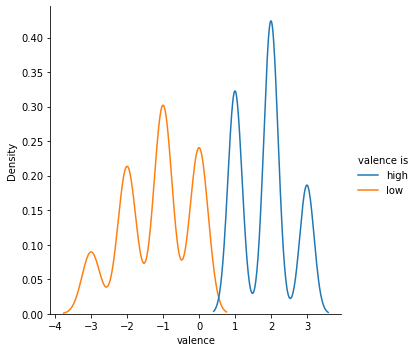

In [131]:
sns.displot(data=VA_df,x='valence',hue='valence is',kind='kde')

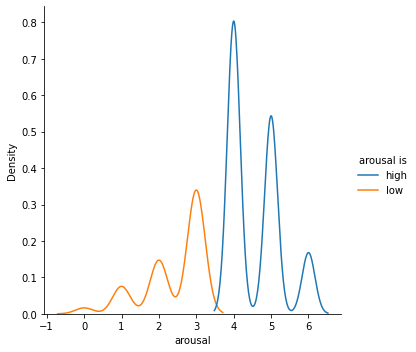

In [132]:
sns.displot(data=VA_df,x='arousal',hue='arousal is',kind='kde')

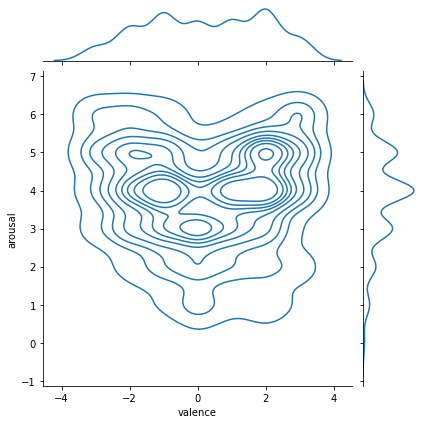

In [133]:
sns.jointplot(x=VA_df['valence'],y=VA_df['arousal'],kind='kde')

comments

## 2.2 Classification

### EEG features extraction

In [134]:
# dataframe from EEG_features
def EEG_features_extraction():

    features_col=['EEG_'+str(i) for i in range(1,89)]

    col = ['participant_ID','recording'] +  features_col
    
    
    EEG_features= pd.DataFrame(columns=col)
    for ID in range(len(data)):

        for i in data[ID]['recordings'].keys():
            
            Big_list= [int(ID+1),int(i)]+ list(data[ID]['recordings'][i]['EEG_features'])
            
            n=len(EEG_features)
            EEG_features.loc[n]=Big_list
    EEG_features = EEG_features.astype({"participant_ID": int, "recording": int})
    return EEG_features

In [135]:
EEG_features=EEG_features_extraction()
EEG_features

,participant_ID,recording,EEG_1,EEG_2,EEG_3,EEG_4,EEG_5,EEG_6,EEG_7,EEG_8,...,EEG_79,EEG_80,EEG_81,EEG_82,EEG_83,EEG_84,EEG_85,EEG_86,EEG_87,EEG_88
0,1,1,319.802936,77.784273,0.226022,6.684862,0.097439,0.107433,-0.091642,0.535000,...,51.116530,0.907231,3.062403,0.154903,0.152405,0.001558,0.641250,0.079950,-0.202391,0.099938
1,1,2,324.279825,93.699272,0.918992,11.327528,0.093691,0.109931,-0.093191,0.513750,...,30.756089,1.680013,6.755662,0.078701,0.100562,0.043425,0.555000,0.159900,-4.854262,0.179888
2,1,3,328.810119,77.724219,1.366203,15.163485,0.102436,0.111181,-0.029519,0.551250,...,107.598947,2.134639,6.751461,0.105559,0.038101,0.171832,0.630625,0.079950,-2.565720,0.099938
3,1,4,323.012492,71.831671,0.607265,10.649928,0.090568,0.099938,-0.054952,0.516875,...,29.367342,1.016118,4.002577,0.163648,0.154279,0.028926,0.635000,0.099938,-1.099257,0.079950
4,1,5,326.936602,127.528419,0.818433,6.451988,0.123673,0.126171,-0.062046,0.488750,...,84.303047,0.249900,2.366839,0.156777,0.206746,0.064842,0.603750,0.139913,-1.532652,0.139913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,44,32,319.661774,121.383061,1.360463,7.843474,0.098064,0.127420,0.030704,0.493750,...,88.109758,0.738419,2.558101,0.191755,0.169269,0.005328,0.633125,0.119925,-0.195278,0.099938
1451,44,33,326.057776,49.612772,-0.137405,4.165165,0.116802,0.129294,0.026058,0.469375,...,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1452,44,34,334.173954,147.638166,0.618607,4.807790,0.119300,0.130543,-0.019658,0.510625,...,23.864094,-2.916185,9.689240,0.000000,0.092442,0.055000,0.000000,0.000000,-1.655617,0.000000
1453,44,35,329.769831,114.584858,0.326679,5.840204,0.098688,0.115553,-0.013322,0.481250,...,383.292063,0.607510,1.472126,0.332917,0.000000,0.439982,0.445625,0.019988,-1.492817,0.059963


### Dataset creation

In [136]:
dataset=VA_df[['participant_ID','recording']]
dataset=pd.merge(ECG_features,EMO_features,on=['participant_ID','recording'])
dataset=pd.merge(dataset,GSR_features,on=['participant_ID','recording'])  
dataset=pd.merge(dataset,EEG_features,on=['participant_ID','recording'])
dataset=pd.merge(dataset,VA_df,on=['participant_ID','recording'])

In [137]:
dataset

,participant_ID,recording,PSD_tlf_1,PSD_tlf_2,PSD_tlf_3,PSD_tlf_4,PSD_tlf_5,PSD_tlf_6,PSD_tlf_7,PSD_tlf_8,...,EEG_83,EEG_84,EEG_85,EEG_86,EEG_87,EEG_88,valence,arousal,valence is,arousal is
0,1,1,0.023458,0.019937,0.015990,0.013766,0.015039,0.020597,0.030211,0.043302,...,0.152405,0.001558,0.641250,0.079950,-0.202391,0.099938,1.0,4.0,high,high
1,1,2,0.013372,0.011560,0.009526,0.008601,0.010194,0.015232,0.023718,0.034796,...,0.100562,0.043425,0.555000,0.159900,-4.854262,0.179888,-1.0,2.0,low,low
2,1,3,0.026298,0.025166,0.023759,0.022638,0.022565,0.024774,0.031149,0.043836,...,0.038101,0.171832,0.630625,0.079950,-2.565720,0.099938,1.0,5.0,high,high
3,1,4,0.056171,0.047546,0.037499,0.030450,0.029671,0.036419,0.050267,0.070173,...,0.154279,0.028926,0.635000,0.099938,-1.099257,0.079950,2.0,4.0,high,high
4,1,5,0.040172,0.033929,0.026638,0.021961,0.023227,0.032270,0.048873,0.071187,...,0.206746,0.064842,0.603750,0.139913,-1.532652,0.139913,1.0,5.0,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,44,32,0.026868,0.023558,0.020244,0.019246,0.022373,0.030448,0.043436,0.061009,...,0.169269,0.005328,0.633125,0.119925,-0.195278,0.099938,-3.0,5.0,low,high
1451,44,33,0.021099,0.018103,0.014653,0.012617,0.013740,0.019013,0.028368,0.040979,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,6.0,low,high
1452,44,34,0.023773,0.020028,0.015991,0.013779,0.014752,0.019213,0.026901,0.037886,...,0.092442,0.055000,0.000000,0.000000,-1.655617,0.000000,-3.0,4.0,low,high
1453,44,35,0.013590,0.012094,0.011057,0.012063,0.016372,0.024515,0.036365,0.051624,...,0.000000,0.439982,0.445625,0.019988,-1.492817,0.059963,-1.0,3.0,low,low


### Preprocessing

In [140]:
df = dataset
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# col_name = df.columns.to_series()[np.isinf(df).any()]
df =  df.fillna(df.mean())
dataset = df

In [141]:
columns=list(dataset.columns)
for col in columns:
    print(col,'-----------------',dataset[col].isnull().sum())
# some of the EEG values are nan

for col in dataset.columns:
    print( col,'------------------',np.sum(dataset[col]==np.infty) )
    
# We have infinite values in EEG 10 and EEG 65

participant_ID ----------------- 0
recording ----------------- 0
PSD_tlf_1 ----------------- 0
PSD_tlf_2 ----------------- 0
PSD_tlf_3 ----------------- 0
PSD_tlf_4 ----------------- 0
PSD_tlf_5 ----------------- 0
PSD_tlf_6 ----------------- 0
PSD_tlf_7 ----------------- 0
PSD_tlf_8 ----------------- 0
PSD_tlf_9 ----------------- 0
PSD_tlf_10 ----------------- 0
PSD_flf_1_x ----------------- 0
PSD_flf_2_x ----------------- 0
PSD_flf_3_x ----------------- 0
PSD_flf_4_x ----------------- 0
RR_mean ----------------- 0
RR_std ----------------- 0
RR_kurtosis ----------------- 0
RR_above ----------------- 0
RR_below ----------------- 0
hr_mean ----------------- 0
hr_std ----------------- 0
hr_kurtosis ----------------- 0
hr_above ----------------- 0
hr_below ----------------- 0
hrv_mean ----------------- 0
hrv_std ----------------- 0
hrv_kurtosis ----------------- 0
hrv_above ----------------- 0
hrv_below ----------------- 0
ECG_HRV_pNN20 ----------------- 0
ECG_HRV_pNN50 ----------------- 

In [142]:
# replace the nan with the most frequent values
dataset=dataset.fillna(dataset.mode().iloc[0])

# replace the infinite values by 0 
dataset=dataset.replace(np.inf,0)

In [143]:
# changing low to 0 and high to 1
dataset[['valence is','arousal is']]=dataset[['valence is','arousal is']].applymap(lambda x: int(x=='high'))

In [144]:
dataset

,participant_ID,recording,PSD_tlf_1,PSD_tlf_2,PSD_tlf_3,PSD_tlf_4,PSD_tlf_5,PSD_tlf_6,PSD_tlf_7,PSD_tlf_8,...,EEG_83,EEG_84,EEG_85,EEG_86,EEG_87,EEG_88,valence,arousal,valence is,arousal is
0,1,1,0.023458,0.019937,0.015990,0.013766,0.015039,0.020597,0.030211,0.043302,...,0.152405,0.001558,0.641250,0.079950,-0.202391,0.099938,1.0,4.0,1,1
1,1,2,0.013372,0.011560,0.009526,0.008601,0.010194,0.015232,0.023718,0.034796,...,0.100562,0.043425,0.555000,0.159900,-4.854262,0.179888,-1.0,2.0,0,0
2,1,3,0.026298,0.025166,0.023759,0.022638,0.022565,0.024774,0.031149,0.043836,...,0.038101,0.171832,0.630625,0.079950,-2.565720,0.099938,1.0,5.0,1,1
3,1,4,0.056171,0.047546,0.037499,0.030450,0.029671,0.036419,0.050267,0.070173,...,0.154279,0.028926,0.635000,0.099938,-1.099257,0.079950,2.0,4.0,1,1
4,1,5,0.040172,0.033929,0.026638,0.021961,0.023227,0.032270,0.048873,0.071187,...,0.206746,0.064842,0.603750,0.139913,-1.532652,0.139913,1.0,5.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,44,32,0.026868,0.023558,0.020244,0.019246,0.022373,0.030448,0.043436,0.061009,...,0.169269,0.005328,0.633125,0.119925,-0.195278,0.099938,-3.0,5.0,0,1
1451,44,33,0.021099,0.018103,0.014653,0.012617,0.013740,0.019013,0.028368,0.040979,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,6.0,0,1
1452,44,34,0.023773,0.020028,0.015991,0.013779,0.014752,0.019213,0.026901,0.037886,...,0.092442,0.055000,0.000000,0.000000,-1.655617,0.000000,-3.0,4.0,0,1
1453,44,35,0.013590,0.012094,0.011057,0.012063,0.016372,0.024515,0.036365,0.051624,...,0.000000,0.439982,0.445625,0.019988,-1.492817,0.059963,-1.0,3.0,0,0


In [145]:
# counting the number of recording per participant
dataset.groupby('participant_ID')['recording'].count()
# all the participants do not have the same number of recording

participant_ID
1     36
2     36
3     36
4     36
5     36
6     34
7     36
8     36
9     18
10    36
11    29
12    36
13    36
14    36
15    36
16    23
17    30
18    36
19    36
20    36
21    36
22    36
23    32
24    22
25    36
26    35
27    35
28    36
29    36
30    36
31    32
32    36
33    29
34    36
35    36
36    36
37    20
38    18
39    36
40    19
41    36
42    36
43    35
44    36
Name: recording, dtype: int64

In [146]:
X=dataset.drop(['participant_ID','recording','valence is','arousal is','valence','arousal'],axis=1)

In [147]:
y_v = dataset['valence is']
y_a=dataset['arousal is']

### Training

In [148]:
# custom fold for one-participant-out-validation

L=list(dataset.groupby('participant_ID')['recording'].count())
for i in range(1,len(L)):
    L[i]+=L[i-1]
L=[0]+L
index=set(range(0,1455))
custom_fold=[]
for i in range(1,len(L)):
    test_fold=list(index)[L[i-1]:L[i]]
    train_fold=list(index-set(test_fold))
    custom_fold.append((train_fold,test_fold) )

# custom fold for one-clip-out-validation

G = list(dataset['recording'].unique()) 

loo_fold=[]
for i in G:
    test_fold=list(dataset[dataset['recording']==i].index)
    train_fold = list(dataset[dataset['recording']!=i].index)
    loo_fold.append((train_fold,test_fold))
 

In [149]:
def training_scoring(model,y,fold):
    
    # scores and confusion matrix
    Scores={'accuracy':[],'precision':[],'recall':[],'f1_score':[],'confusion_matrix':np.zeros((2,2))}
    for i, j in fold:
        X_train, y_train = X.iloc[i], y[i]
        X_test, y_test = X.iloc[j], y[j]
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        Scores['accuracy'].append(metrics.accuracy_score(y_test,y_pred))
        precision,recall,f1_score,_=metrics.precision_recall_fscore_support(y_test,y_pred, average='macro',warn_for=tuple())
        Scores['precision'].append(precision)
        Scores['recall'].append(recall)
        Scores['f1_score'].append(f1_score)
        Scores['confusion_matrix']+=metrics.confusion_matrix(y_test,y_pred)
    
    print('model averaged accuracy: ', np.mean(Scores['accuracy']) )
    print('model averaged precision: ', np.mean(Scores['precision']) )
    print('model averaged recall: ', np.mean( Scores['recall']) )
    print('model averaged f1_score: ',np.mean(Scores['f1_score']))
    plt.figure()
    sns.heatmap(Scores['confusion_matrix'],annot=True)
    plt.show()
    
    return Scores

In [150]:
# model
model_val_1 = RandomForestClassifier()
model_val_2 = RandomForestClassifier()
model_ar_1 = RandomForestClassifier()
model_ar_2 = RandomForestClassifier()
models=[model_val_1,model_val_2,model_ar_1,model_ar_2]
models_name=['Valence model with leave-one participant out',
             'Valence model with leave-one clip out',
             'Arousal model with leave-one participant out',
             'Arousal model with leave-one clip out']

leave-one participant out validation for Valence
model averaged accuracy:  0.8510366452824701
model averaged precision:  0.8533033433284981
model averaged recall:  0.8595337419297997
model averaged f1_score:  0.8449793664324482


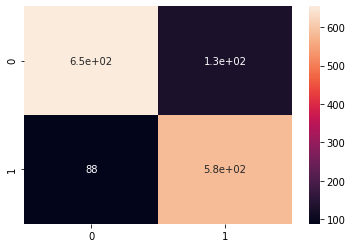

---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
leave-one clip out validation for Valence
model averaged accuracy:  0.5552192231958331
model averaged precision:  0.3893608464931074
model averaged recall:  0.5096523701690647
model averaged f1_score:  0.34826307664455214


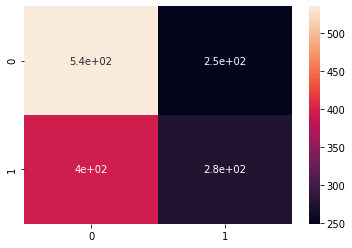

In [151]:
# VALENCE
# leave-one participant out validation 
print('leave-one participant out validation for Valence')
Scores_valence_part = training_scoring(model_val_1,y_v,custom_fold)
print('---------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------')
print('leave-one clip out validation for Valence')
# leave-one clip out validation 
Scores_valence_loo=training_scoring(model_val_2,y_v,loo_fold)

leave-one participant out validation for Arousal
model averaged accuracy:  0.662635944775741
model averaged precision:  0.6004150165787352
model averaged recall:  0.5641144631254752
model averaged f1_score:  0.536088637567953


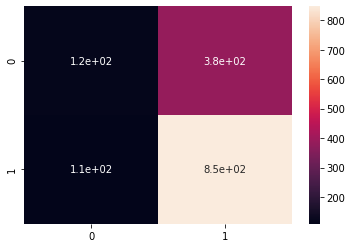

---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
leave-one clip out validation for Arousal
model averaged accuracy:  0.6349837585586308
model averaged precision:  0.42395030995180494
model averaged recall:  0.4986019039139566
model averaged f1_score:  0.40907381114856595


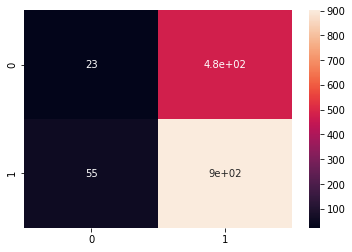

In [152]:
# AROUSAL
# leave-one participant out validation 
print('leave-one participant out validation for Arousal')
Scores_arousal_part = training_scoring(model_ar_1,y_a,custom_fold)
print('---------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------')
print('leave-one clip out validation for Arousal')
# leave-one clip out validation 
Scores_arousal_loo=training_scoring(model_ar_2,y_a,loo_fold)

### Most important features

In [153]:
def features_importances(model,nb_features=11):
    names=list(X.columns)
    imp = model.feature_importances_
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure()
    plt.barh(range(len(names))[:nb_features], imp[:nb_features], align='center')
    plt.yticks(range(len(names))[:nb_features], names[:nb_features])
    plt.show()



---------------------------------------------->  Valence model with leave-one participant out  <----------------------------------------------


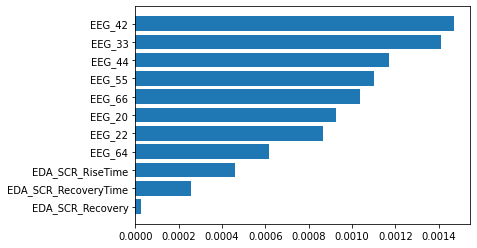

--------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------->  Valence model with leave-one clip out  <----------------------------------------------


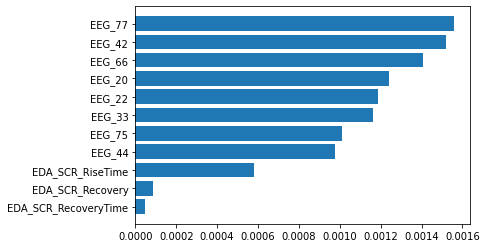

--------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------->  Arousal model with leave-one participant out  <----------------------------------------------


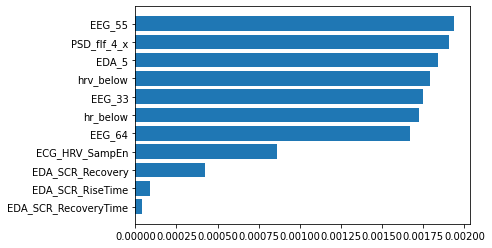

--------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------->  Arousal model with leave-one clip out  <----------------------------------------------


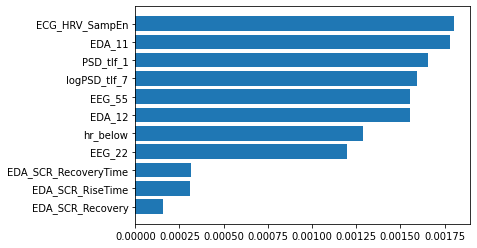

--------------------------------------------------------------------------------------------------------------------------------------


In [154]:
for i in range(len(models)):
    print('----------------------------------------------> ',models_name[i],' <----------------------------------------------')
    features_importances(models[i])
    print('--------------------------------------------------------------------------------------------------------------------------------------')

### Zero Rule algorithm

In [155]:
from sklearn.dummy import DummyClassifier
Zero_rule_model_val_1 = DummyClassifier(strategy="most_frequent")
Zero_rule_model_val_2 = DummyClassifier(strategy="most_frequent")
Zero_rule_model_ar_1 = DummyClassifier(strategy="most_frequent")
Zero_rule_model_ar_2 = DummyClassifier(strategy="most_frequent")

model averaged accuracy:  0.5425386248865096
model averaged precision:  0.2712693124432548
model averaged recall:  0.5
model averaged f1_score:  0.3475842728647547


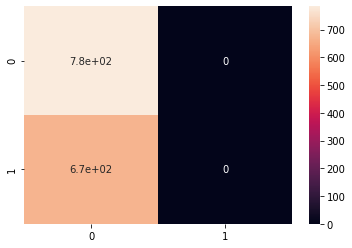

---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
model averaged accuracy:  0.5362802042808834
model averaged precision:  0.2681401021404417
model averaged recall:  0.5
model averaged f1_score:  0.30920986842662695


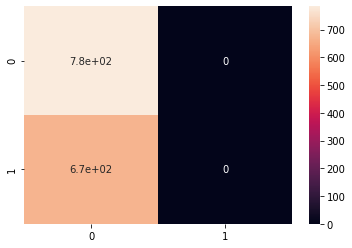

In [156]:
# VALENCE
# leave-one participant out validation 
Scores_valence_part = training_scoring(Zero_rule_model_val_1,y_v,custom_fold)
print('---------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------')
# leave-one participant out validation 
Scores_valence_loo=training_scoring(Zero_rule_model_val_2,y_v,loo_fold)

model averaged accuracy:  0.6607140579296839
model averaged precision:  0.34172066532847833
model averaged recall:  0.5113636363636364
model averaged f1_score:  0.40497493323491796


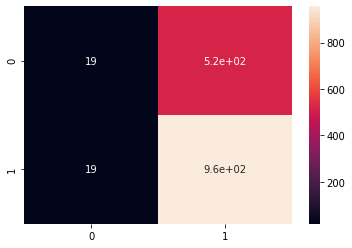

---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
model averaged accuracy:  0.6568571309807465
model averaged precision:  0.32842856549037325
model averaged recall:  0.5
model averaged f1_score:  0.39023400442530876


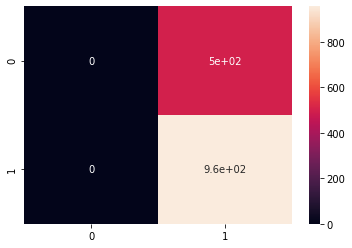

In [157]:
# AROUSAL
# leave-one participant out validation 
Scores_valence_part = training_scoring(Zero_rule_model_ar_1,y_a,custom_fold)
print('---------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------')
# leave-one participant out validation 
Scores_valence_loo=training_scoring(Zero_rule_model_ar_2,y_a,loo_fold)

Comments

## 2.3 Discussion

### Model generalization accros people and clips

In [158]:
np.std(Scores_valence_part['accuracy']),np.std(Scores_valence_part['precision']),np.std(Scores_valence_part['recall']),np.std(Scores_valence_part['f1_score'])

(0.13976983119588227,
 0.11954961082130482,
 0.07451634686706819,
 0.10260809946447451)

In [159]:
np.std(Scores_valence_loo['accuracy']),np.std(Scores_valence_loo['precision']),np.std(Scores_valence_loo['recall']),np.std(Scores_valence_loo['f1_score'])

(0.16511031035614343, 0.08255515517807172, 0.0, 0.06270037390594993)

In [160]:
np.std(Scores_arousal_part['accuracy']),np.std(Scores_arousal_part['precision']),np.std(Scores_arousal_part['recall']),np.std(Scores_arousal_part['f1_score'])

(0.11034983416893114,
 0.11820912925997996,
 0.08146743035678031,
 0.10317021306011902)

In [161]:
np.std(Scores_arousal_loo['accuracy']),np.std(Scores_arousal_loo['precision']),np.std(Scores_arousal_loo['recall']),np.std(Scores_arousal_loo['f1_score'])

(0.15384972089992763,
 0.1634300841278657,
 0.03866495480324273,
 0.06500818277161535)

### Models performance for very high and low Valence and Arousal

In [162]:
Best_val_model= model_val_1
Best_ar_model = model_ar_1

In [163]:
# Valence

dataset_val_norm = dataset[ (dataset['valence'] >= -2) & (dataset['valence'] <= 2) ]
dataset_val_extremum=dataset[ (dataset['valence'] == -3) | (dataset['valence'] == 3) ]

X_test_val_norm = dataset_val_norm.drop(['participant_ID','recording','valence is','arousal is','valence','arousal'],axis=1)
y_test_val_norm = dataset_val_norm['valence is']

X_test_val_extremum = dataset_val_extremum.drop(['participant_ID','recording','valence is','arousal is','valence','arousal'],axis=1)
y_test_val_extremum = dataset_val_extremum['valence is']

# Arousal
dataset_ar_norm = dataset[ (dataset['arousal'] >= 1) & (dataset['arousal'] <= 5) ]
dataset_ar_extremum=dataset[ (dataset['arousal'] == 0) | (dataset['arousal'] == 6) ]

X_test_ar_norm = dataset_ar_norm.drop(['participant_ID','recording','valence is','arousal is','valence','arousal'],axis=1)
y_test_ar_norm = dataset_ar_norm['arousal is']

X_test_ar_extremum = dataset_ar_extremum.drop(['participant_ID','recording','valence is','arousal is','valence','arousal'],axis=1)
y_test_ar_extremum = dataset_ar_extremum['arousal is']






In [164]:
def model_performance(model,X_test,y_test):

    # scores and confusion matrix
    Scores={'accuracy':0.0,'precision':0.0,'recall':0.0,'f1_score':0.0,'confusion_matrix':np.zeros((2,2))}

    y_pred=model.predict(X_test)
    Scores['accuracy']=metrics.accuracy_score(y_test,y_pred)
    precision,recall,f1_score,_=metrics.precision_recall_fscore_support(y_test,y_pred, average='macro',warn_for=tuple())
    Scores['precision']=precision
    Scores['recall']=recall
    Scores['f1_score']=f1_score
    Scores['confusion_matrix']=metrics.confusion_matrix(y_test,y_pred)

    print('model averaged accuracy: ', Scores['accuracy']) 
    print('model averaged precision: ', Scores['precision']) 
    print('model averaged recall: ', Scores['recall']) 
    print('model averaged f1_score: ',Scores['f1_score'])
    plt.figure()
    sns.heatmap(Scores['confusion_matrix'],annot=True)
    plt.show()

In [165]:
# creating a testing list
Test_comp=[(X_test_val_norm,y_test_val_norm),(X_test_val_extremum,y_test_val_extremum),
           (X_test_ar_norm,y_test_ar_norm),(X_test_ar_extremum,y_test_ar_extremum)]
Test_comp_names=['Testing the model for non-very high and non-very low valence',
                    'Testing the model for very high and very low valence',
                    'Testing the model for non-very high and non-very low arousal',
                    'Testing the model for very high and very low arousal']

---------------------------------------------->  Testing the model for non-very high and non-very low valence  <----------------------------------------------
model averaged accuracy:  0.994345718901454
model averaged precision:  0.9937465538448489
model averaged recall:  0.9947893007329247
model averaged f1_score:  0.9942508871452995


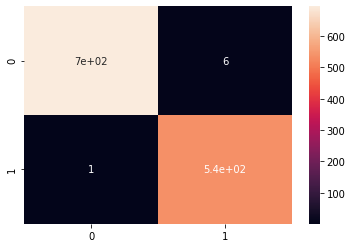

--------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------->  Testing the model for very high and very low valence  <----------------------------------------------
model averaged accuracy:  1.0
model averaged precision:  1.0
model averaged recall:  1.0
model averaged f1_score:  1.0


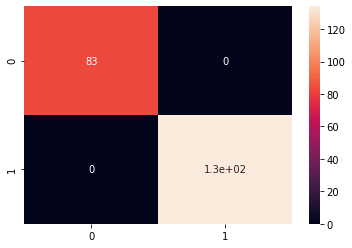

--------------------------------------------------------------------------------------------------------------------------------------


In [166]:
for i in range(2):
    print('----------------------------------------------> ',Test_comp_names[i],' <----------------------------------------------')
    X_test_,y_test_=Test_comp[i]
    model_performance(Best_val_model,X_test_,y_test_)
    print('--------------------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------->  Testing the model for non-very high and non-very low arousal  <----------------------------------------------
model averaged accuracy:  0.9910112359550561
model averaged precision:  0.9916114666458549
model averaged recall:  0.9889569436021831
model averaged f1_score:  0.9902589347822914


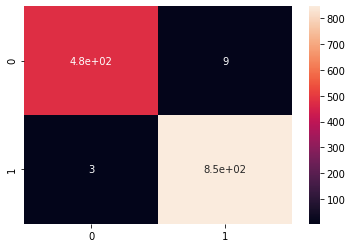

--------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------->  Testing the model for very high and very low arousal  <----------------------------------------------
model averaged accuracy:  1.0
model averaged precision:  1.0
model averaged recall:  1.0
model averaged f1_score:  1.0


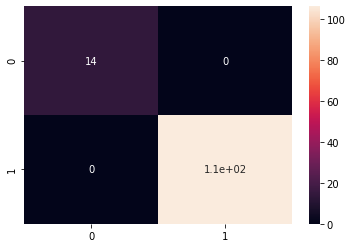

--------------------------------------------------------------------------------------------------------------------------------------


In [167]:
for i in range(2,4):
    print('----------------------------------------------> ',Test_comp_names[i],' <----------------------------------------------')
    X_test_,y_test_=Test_comp[i]
    model_performance(Best_ar_model,X_test_,y_test_)
    print('--------------------------------------------------------------------------------------------------------------------------------------')